<a href="https://colab.research.google.com/github/JeLaKo/apple-tree-disease/blob/main/Milestone4b_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data and importing the necessary libraries

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [22]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math as tfmath
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns

In [3]:
# import mlxtend package for confusion matrix
import mlxtend
                                                          
print(mlxtend.__version__) 

! pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


0.19.0
0.19.0


In [4]:
'''
Only run the following cells if data needs to be newly downloaded !
'''
# !pip install -U -q kaggle==1.5.8

'\nOnly run the following cells if data needs to be newly downloaded !\n'

In [5]:
# %cd /content/gdrive/MyDrive/MLP/

In [6]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
# ! kaggle competitions download -c plant-pathology-2021-fgvc8

In [7]:
# ! mkdir train

In [8]:
# ! unzip -q plant-pathology-2021-fgvc8.zip -d train

Data processing


In [9]:
%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [10]:
# read training data
df = pd.read_csv('train.csv')
print(df.head(2))

                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex


In [11]:
# remove all combined classes from dataset
df = df.set_index('labels')
df = df.drop('scab frog_eye_leaf_spot complex', axis = 0)
df = df.drop('scab frog_eye_leaf_spot', axis = 0)
df = df.drop('frog_eye_leaf_spot complex', axis = 0)
df = df.drop('powdery_mildew complex', axis = 0)
df = df.drop('rust complex', axis = 0)
df = df.drop('rust frog_eye_leaf_spot', axis = 0)
df = df.drop('complex', axis = 0)
df = df.reset_index()
print(df.head())

new_labels = df['labels'].to_list()
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)

    labels                 image
0  healthy  800113bb65efe69e.jpg
1     scab  80070f7fb5e2ccaa.jpg
2     scab  80077517781fb94f.jpg
3  healthy  800edef467d27c15.jpg
4     rust  800f85dc5f407aef.jpg


In [14]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """
  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """
  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

In [15]:
'''
Run this cell if network is trained using all of the data !
'''
# df_onehot = one_hot(df)
# print(df_onehot.head(2))

'\nRun this cell if network is trained using all of the data !\n'

In [16]:
'''
Run this cell if network is trained with only a sample !
'''
# select sample from dataframe
df_sampled = sample(df, 1184)
print(df_sampled.head(2))

# convert labels within dataframe to one-hot encoded classes
df_onehot = one_hot(df_sampled)
print(df_onehot.head(2))

                      image adjusted labels
12452  e871c3ced550aaaa.jpg         healthy
3612   a1d196b94b8f6d60.jpg         healthy
                      image  frog_eye_leaf_spot  ...  rust  scab
12452  e871c3ced550aaaa.jpg                   0  ...     0     0
3612   a1d196b94b8f6d60.jpg                   0  ...     0     0

[2 rows x 6 columns]


Image-data processing

In [ ]:
'''
Only run this cell if images need resizing !
'''
# # create new directory
# ! mkdir resized_train_images

# # gather names of all images in the image-directory
# train_images = os.listdir('train_images/')

# # resize all images and save it to a new directory 
# for image in train_images:
#   img = cv2.imread('train_images/' + image)
#   resized_img = cv2.resize(img, (96, 96)) 
#   cv2.imwrite('resized_train_images/' + image, resized_img)


In [17]:
# convert dataframe to a hashable list; dictionary
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the resized directory
resized_images = os.listdir('resized_train_images/')

images = []
# find corresponding image from the resized directory to the selected sample found
# in dictionary and add that to a list
for image in df_dict.keys():
  if image in resized_images:
    img_resized = cv2.imread('resized_train_images/' + image) 
    images.append(img_resized)

In [18]:
# convert image list to array
images = np.array(images)

# convert dictionary values to array
labels = np.array(list(df_dict.values()))

# split data
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

Building and training the network

In [36]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}, class_weight = {}):

    # optimizer = keras.optimizers.Adam(lr = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y), class_weight = class_weight)

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [48]:
# compute class-weights for inbalanced data
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
class_weight = dict(enumerate(class_weights))

In [ ]:
# ML MODEL ARCHITECTURE
# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 128 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 256 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 32 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten layers
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5)))

# apply softmax activation for final layer classification
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# augment data: set augmentation dictionary
augment = {'horizontal_flip': True, 
           'vertical_flip': True, 
           'rotation_range': 20, 
           'width_shift_range': 0.1, 
           'height_shift_range': 0.1, 
           'zoom_range': [0,1.5], 
           'brightness_range': [0,1.5],
           'channel_shift_range' : 0.9,
           'shear_range' : 0.9}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess, epochs = 80, augment = augment, class_weight = class_weight)


Epoch 1/80
130/130 [==============================] - 20s 134ms/step - loss: 2.2696 - accuracy: 0.2370 - val_loss: 1.4935 - val_accuracy: 0.3508
Epoch 2/80
130/130 [==============================] - 17s 133ms/step - loss: 1.8194 - accuracy: 0.2734 - val_loss: 1.4541 - val_accuracy: 0.3412
Epoch 3/80
130/130 [==============================] - 18s 135ms/step - loss: 1.7585 - accuracy: 0.2679 - val_loss: 1.4452 - val_accuracy: 0.3682
Epoch 4/80
130/130 [==============================] - 18s 140ms/step - loss: 1.6742 - accuracy: 0.2862 - val_loss: 1.4717 - val_accuracy: 0.2967
Epoch 5/80
130/130 [==============================] - 17s 132ms/step - loss: 1.6315 - accuracy: 0.2942 - val_loss: 1.5063 - val_accuracy: 0.3688
Epoch 6/80
130/130 [==============================] - 18s 135ms/step - loss: 1.5943 - accuracy: 0.3002 - val_loss: 1.4065 - val_accuracy: 0.4116
Epoch 7/80
130/130 [==============================] - 17s 133ms/step - loss: 1.5714 - accuracy: 0.3019 - val_loss: 1.3534 - val_ac

In [ ]:
model.summary()

Confusion Matrix

array(['healthy', 'scab', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew'],
      dtype=object)

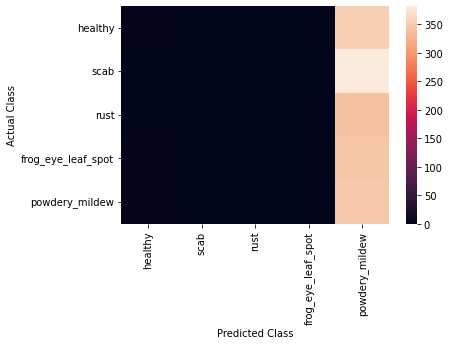

tf.Tensor(
[[  2   0   0   1 353]
 [  1   0   0   0 382]
 [  0   0   0   0 340]
 [  3   0   0   0 344]
 [  3   0   0   0 347]], shape=(5, 5), dtype=int32)


In [32]:
# select classes
classes = df['adjusted labels'].unique()
display(classes)

# gather actual and predicted classes
y_true = tf.argmax(y_val, axis=1)
y_pred = tf.argmax(model.predict(x_val), axis = 1)

# plot confusion matrix 1
conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes = 5)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

In [ ]:
# plot confusion matrix 2
mtrx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mtrx, figsize=(8, 8), class_names=classes, colorbar=True, show_normed = True)

In [ ]:
# # VGG-16 model

# # Define Sequential model
# modelVGG_16 = models.Sequential()

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu",input_shape=(96, 96, 3)))
# modelVGG_16.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # # create convolutional layers and max pooling layer
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # flatten layer
# modelVGG_16.add(layers.Flatten())
# modelVGG_16.add(layers.Dense(4096, activation="relu"))
# modelVGG_16.add(tf.keras.layers.Dropout(0.5))
# modelVGG_16.add(layers.Dense(4096, activation="relu"))
# modelVGG_16.add(tf.keras.layers.Dropout(0.5))

# # predict
# modelVGG_16.add(layers.Dense(6, activation='softmax'))

# # normalize input data: set preprocesing dictionary
# preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# # augment data: set augmentation dictionary
# augment = {'horizontal_flip': True, 
#            'vertical_flip': True, 
#            'rotation_range': 20, 
#            'width_shift_range': 0.1, 
#            'height_shift_range': 0.1, 
#            'zoom_range': [0,1.5], 
#            'brightness_range': [0,1.5],
#            'channel_shift_range' : 0.9,
#            'shear_range' : 0.9}

# # run training and evaluation function
# train_and_evaluate(modelVGG_16, x_train, y_train, x_val, y_val, preprocess, epochs = 80, augment = augment)

In [ ]:
# modelVGG_16.summary()